# Introduction

Do not spend too much time trying to get very tiny metrics improvement. Once you have a model with a correct predictive power, you should better spend time explaining your data cleaning & preparation pipeline as well as explanations & visualizations of the results.

The goal is to see your fit with our company culture & engineering needs, spending 50h on an over-complicated approach will not give you bonus points compared to a simple, yet effective, to-the-point solution.

## About the data

The dataset you will be working with is called Emo-DB and can be found [here](http://emodb.bilderbar.info/index-1280.html).

It is a database containing samples of emotional speech in German. It contains samples labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information")
   
The goal of this project is to develop a model which is able to **classify samples of emotional speech**. Feel free to use any available library you would need, but beware of re-using someone else's code without mentionning it!

## Deliverable

The end-goal is to deliver us a zip file containing:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work
* A Dockerfile which defines a container for the project. The container should handle everything (download the data, run the code, etc...). When running the container it should expose the jupyter notebook on one port and expose a Flask API on another one. The Flask app contains two endpoints:
  - One for training the model
  - One for querying the last trained model with an audio file of our choice in the dataset
* A README.md which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* Any necessary .py, .sh or other files needed to run your code.

# Libraries Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
from sklearn.model_selection import train_test_split as tts

# To read wav files
from scipy.io import wavfile
import librosa

In [3]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Data Preparation & Cleaning

In [4]:
DATA_PATH = "data/"
WAV_PATH = "wav/"
LABEL_INDEX = 5

# Get a list of all the wav file names
filenames = sorted(os.listdir(DATA_PATH + WAV_PATH))

In [5]:
german_to_labels = {'W' : 0,
                    'L' : 1,
                    'E' : 2,
                    'A' : 3,
                    'F' : 4,
                    'T' : 5,
                    'N' : 6}

label_to_description = {0 : 'Anger',
                        1 : 'Boredom',
                        2 : 'Disgust',
                        3 : 'Fear',
                        4 : 'Happiness',
                        5 : 'Sadness',
                        6 : 'Neutral'}

Emotion:  Happiness


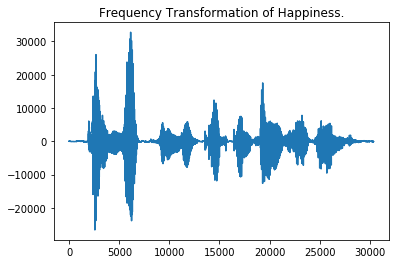

Emotion:  Neutral


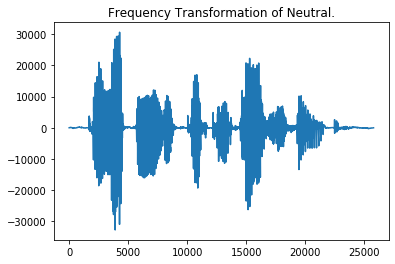

Emotion:  Anger


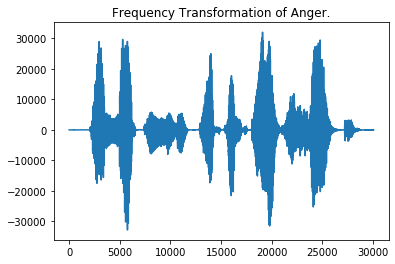

Emotion:  Happiness


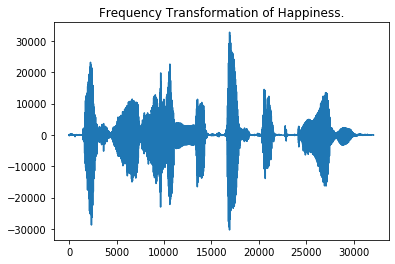

Emotion:  Neutral


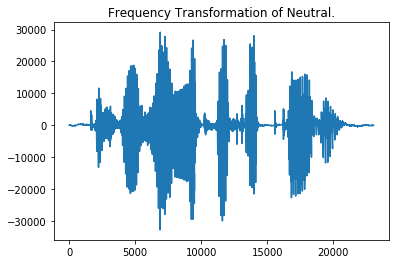

In [83]:
for i in range(5):
    wav = wavfile.read(DATA_PATH + WAV_PATH + filenames[i])
    german_emotion = filenames[i][LABEL_INDEX]

    print("Emotion: ", label_to_description[german_to_labels[german_emotion]])
    plt.plot(wav[1])
    plt.title("Frequency Transformation of {}.".format(label_to_description[german_to_labels[german_emotion]]))
    plt.show()

In [7]:
wavs = []
labels = []

for f in filenames:
    labels.append(german_to_labels[f[LABEL_INDEX]])
    wavs.append(wavfile.read(DATA_PATH + WAV_PATH + f))

y = np.array(labels)

/home/fanconic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


Check label distribution

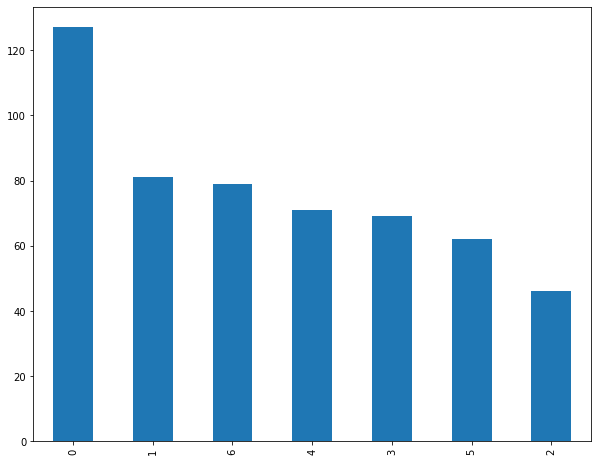

In [64]:
plt.figure(figsize=(10,8))
pd.Series(y).value_counts().plot(kind="bar")

In [9]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)

We want to check if all the wav files have the same frequency.

In [10]:
SAMPLE_RATE = wavs[0][0] 
(SAMPLE_RATE == np.array([x[0] for x in wavs])).all()

True

In [11]:
values = [x[1] for x in wavs]

# Feature Engineering & Modeling

In [12]:
# Source: https://data-flair.training/blogs/python-mini-project-speech-emotion-recognition/


def extract_feature(X, sample_rate, 
                    mfcc=True, chroma= False, mel= False):
    """
    This function creates features, to be used for speech emotion recognition
    params:
        X: the frequencies of the speech
        sample_rate: the rate of the frequencies
        mfcc (default = True): Mel-frequency cepstrum coefficients - which bins the various 
                               frequencies into a heatmap.
        chroma (default = False): Additional Chroma transformation
        mel (default = False): Addtional mel transormation
    return:
        Features based on the MFCC transformation
    """
    X = X.astype("float32")
    if chroma:
        stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma:
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [13]:
x = []
for v in values:
    x.append(extract_feature(v, SAMPLE_RATE, mfcc=True, chroma=True, mel= True))
    
x = np.array(x)
print(x.shape)

(535, 180)


In [14]:
# Normalize Data
x_scaled = preprocessing.scale(x)

/home/fanconic/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Display some MFCC heatmaps.

Emotion: Happiness


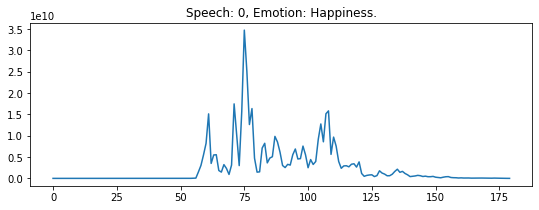

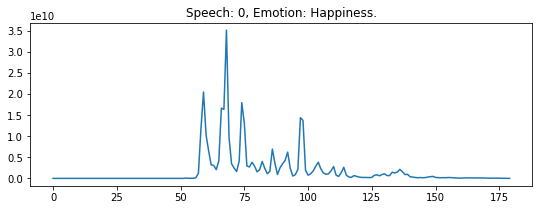

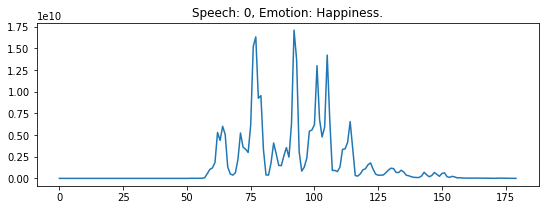

Emotion: Neutral


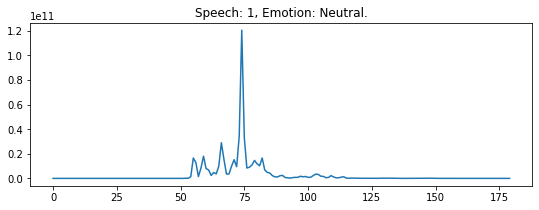

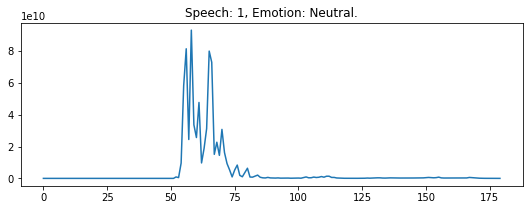

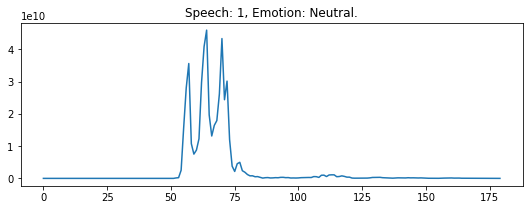

Emotion: Anger


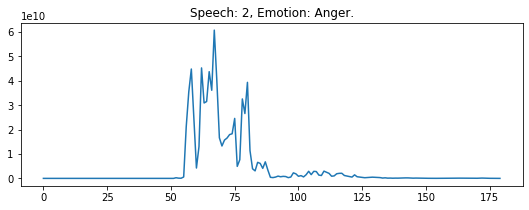

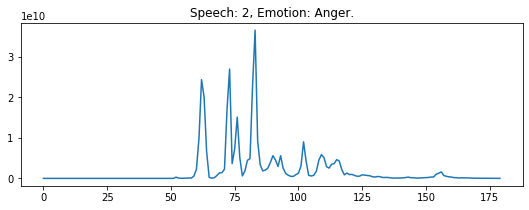

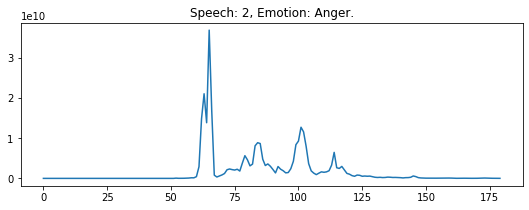

Emotion: Happiness


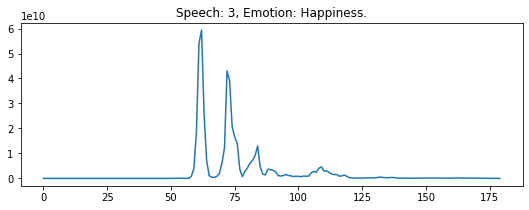

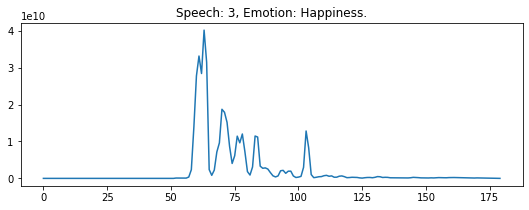

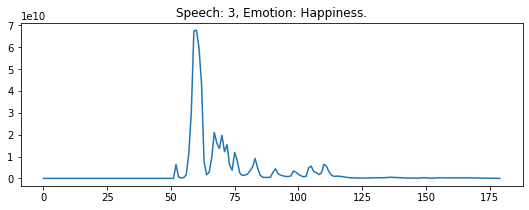

Emotion: Neutral


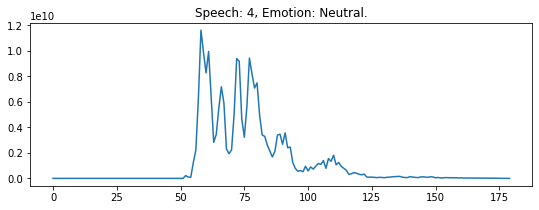

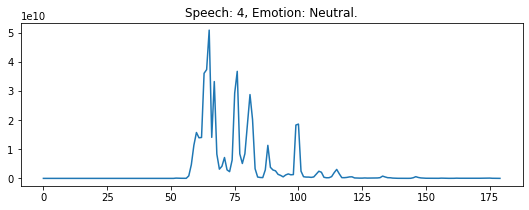

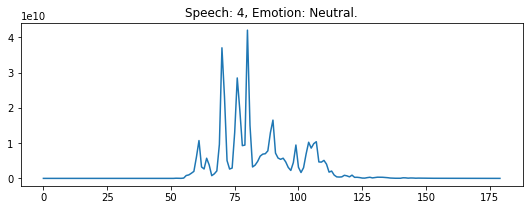

Emotion: Sadness


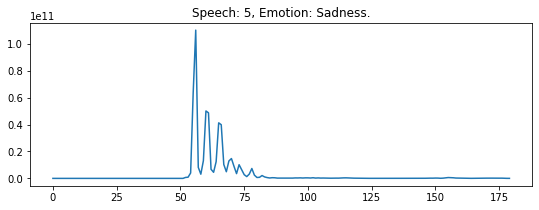

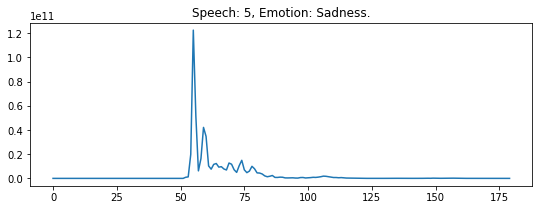

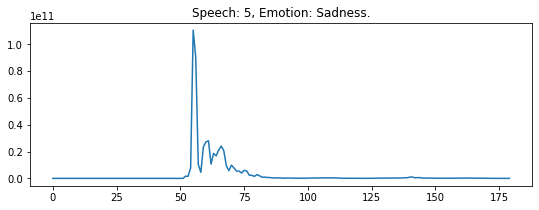

Emotion: Anger


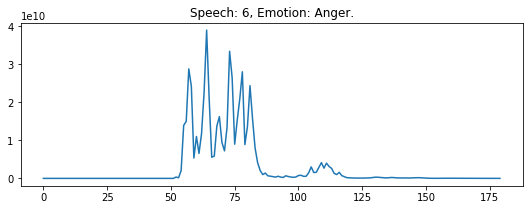

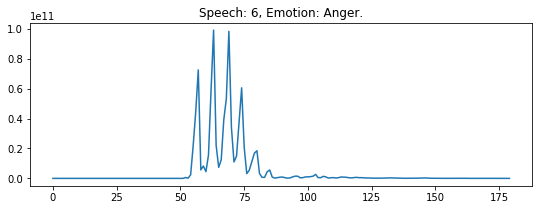

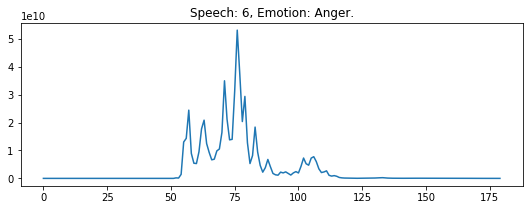

In [62]:
for j in range(7):  
    print("Emotion: {}".format(label_to_description[y[j]]))
    for i in np.where(y == j)[0][:3]:
        plt.figure(figsize=(9,3))
        plt.plot(x[i])
        plt.title("Speech: {}, Emotion: {}.".format(j, label_to_description[y[j]]))
        plt.show()

In [16]:
x_train, x_val, y_train, y_val = tts(x_scaled,y, test_size=0.2)
stf = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

In [17]:
model = SVC(C = 10, class_weight="balanced")

In [18]:
scores = cross_val_score(model, x_scaled, y, cv = stf, scoring="f1_macro")
print(np.array(scores).mean())
print(np.array(scores).std())

0.7576901073242364
0.019862131387328362


In [19]:
model.fit(x_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Results & Visualizations

0.7289719626168224
F1 Macro score:  0.7162484450625809


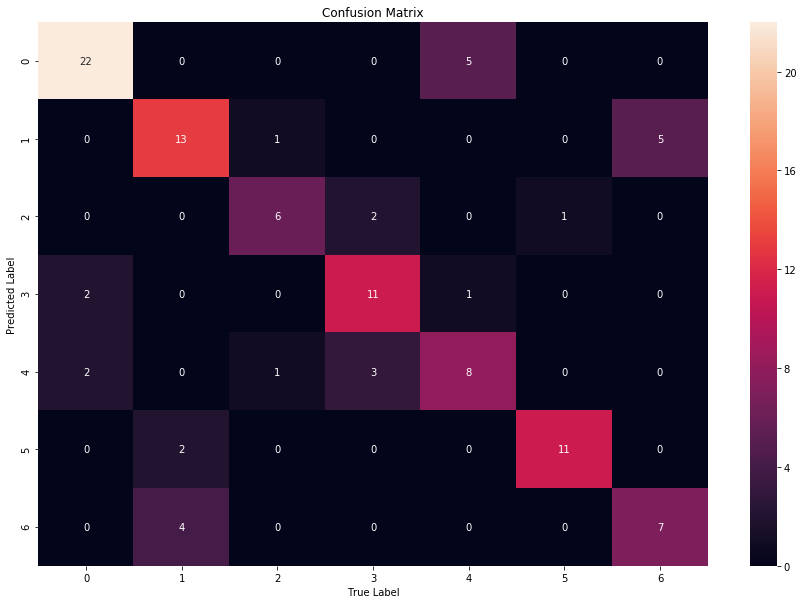

In [79]:
import seaborn as sns
y_pred = model.predict(x_val)
print(accuracy_score(y_val, y_pred))
print("F1 Macro score: ", f1_score(y_val, y_pred, average= 'macro'))
plt.figure(figsize=(15,10))
plt.title("Confusion Matrix")
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

In [68]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_transformed = pca.fit_transform(x_scaled)

In [31]:
y_pred = model.predict(x_scaled)

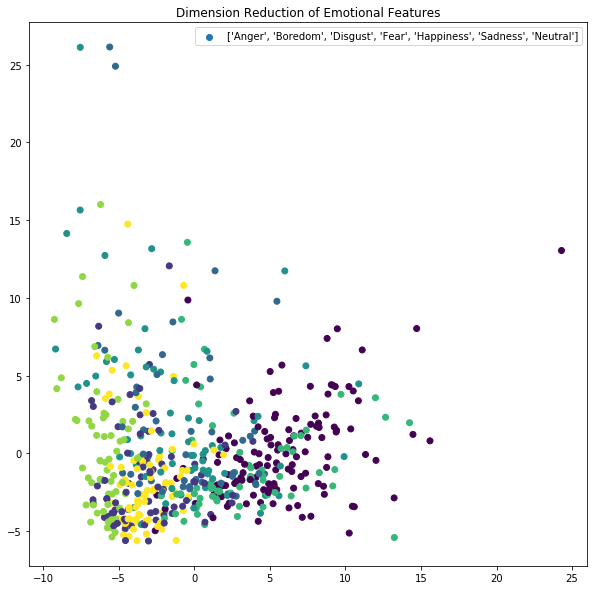

In [47]:
plt.figure(figsize=(10,10))
plt.title("Dimension Reduction of Emotional Features")
plt.scatter(x_transformed[:,0],x_transformed[:,1], c=y, )
plt.legend()

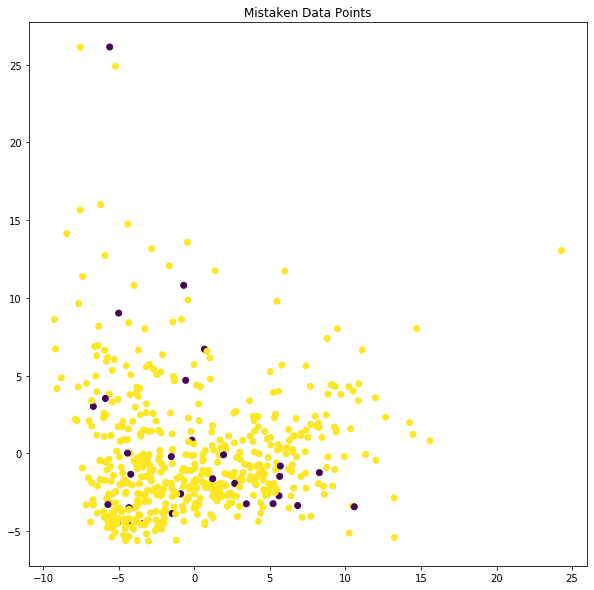

In [66]:
plt.figure(figsize=(10,10))
plt.title("Mistaken Data Points")
plt.scatter(x_transformed[:,0],x_transformed[:,1], c=y==y_pred, )